In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.patches as patches
import matplotlib.colors as colors
import Q2Q1FEM
import PolyFEM
import pandas as pd 
import itertools
from copy import deepcopy
import amplify
from amplify import BinaryPoly, gen_symbols,sum_poly, decode_solution
from amplify import Solver
from amplify.client import FixstarsClient
token = "AE/1WaScy7jya1I2su6uQKSd0z0L11wAY0D "
import time

In [2]:
nelm = 32
wid = 1/3
Node,Element,NodeBC=Q2Q1FEM.RecSquareMeshQ2(nelm,wid)
Node_P,Element_P,NodeBC_P=Q2Q1FEM.RecSquareMeshQ1(nelm,wid) #Don't use NodeBC_P!!!!(NodeBC_P contains the value of the velocity🥶)
fem_NElem = Element.shape[0]
zIni = np.ones(fem_NElem)

In [3]:
adj_elem_list = []
for i in range(fem_NElem-nelm):
    t_adj = []
    if i%nelm!=0:
        t_u = i-1
        t_adj.append(t_u)
    if i>=nelm:
        t_l = i-nelm
        t_adj.append(t_l)
    if i%nelm!=nelm-1:
        t_o = i+1
        t_adj.append(t_o)
    if (nelm*(nelm-1))-i>nelm:
        t_r = i+nelm
        t_adj.append(t_r)
    adj_elem_list.append(t_adj)

In [4]:
def Construct_QUBO(Nelm,nelm,u,v,volfrac,num_bit_per,xc):
    ## bit string
    v_limited = volfrac*(Nelm+nelm)-nelm

    ## coef for porous resistivity
    coef_pr = 10**5/4
    coef_pr_pres = [0 for _ in range(Nelm)]

    ## coef for energy loss, eqn constraint, gradient energy, heviside function, boundary constraint, domain constraints
    alpha_el = 5
    alpha_eqn_c = 1
    alpha_ge = 10.0
    alpha_hev = 300.0
    alpha_bc = 1.0
    alpha_dc = 700.0

    ## qubit
    q = gen_symbols(BinaryPoly,Nelm,num_bit_per+1)

    ## objective function
    obj_func = BinaryPoly()

    ### energy loss
    for t_id in range(Nelm):
        coef_pr_e = (1-q[t_id][-1])*coef_pr
        t_uvec = u[t_id]/xc*2
        t_vvec = v[t_id]/xc*2
        obj_func += alpha_el*(coef_pr_e*(t_uvec*t_uvec+t_vvec*t_vvec) )

    ### gradient energy
    for t_id,t_q in enumerate(q):
        for tt_id in adj_elem_list[t_id]:
            phi_i = (sum_poly(t_q[:-1])/num_bit_per*2)-1
            phi_j = (sum_poly(q[tt_id][:-1])/num_bit_per*2)-1
            obj_func += alpha_ge/2*(phi_i-phi_j)**2
    for t_id in range(nelm):
        t_q = q[t_id]
        phi_i = (sum_poly(t_q[:-1])/num_bit_per*2)-1
        phi_j = 1
        obj_func += alpha_ge/2*(phi_i-phi_j)**2

    ### boundary constraint
    # for t_id, t_q in enumerate(q):
    #     if t_id in in_bound_element+out_bound_element:
    #         obj_func += alpha_bc*((sum_poly(t_q[:-1])/num_bit_per*2)-1 -1)**2
    #     else:
    #         pass

    ### heviside function
    for t_id, t_q in enumerate(q):
        obj_func += alpha_hev*(sum_poly(t_q[:-1])/num_bit_per - t_q[-1])**2

    ### domaint constraints
    obj_func += alpha_dc*(sum_poly([t[-1] for t in q]) - v_limited)**2
    
    client = FixstarsClient()
    client.parameters.timeout = 1000   # タイムアウト X m秒
    client.token = token # ローカル環境で使用する場合は、Amplify AEのアクセストークンを入力してください
    client.parameters.outputs.duplicate = True  # 同じエネルギー値の解を列挙するオプション（解が複数個あるため）

    solver = Solver(client)
    # solver.sort_solution = False # 解をエネルギー順にソートしない
    # solver.client.parameters.outputs.sort = False # 解をエネルギー順にソートしない
    # solver.client.parameters.outputs.num_outputs = 0 # エネルギーの更新ごとに得られたすべての解をsolutionsに含める
    # d = {"sampling_time":[],"energy":[]} #履歴データを格納する
    result = solver.solve(obj_func)
    # for t, s in zip(solver.client_result.timing.time_stamps, result.solutions):
    #     if s.is_feasible:
    #         d["sampling_time"].append(t)
    #         d["energy"].append(s.energy)
    # number=solver.client_result.execution_parameters.num_iterations
    # print("Solved",flush=True)
    #print(d)

    solution = decode_solution(q, result[0].values)
    
    return solution

f:24.21667727164487
Volume fraction: 0.5387369791666667


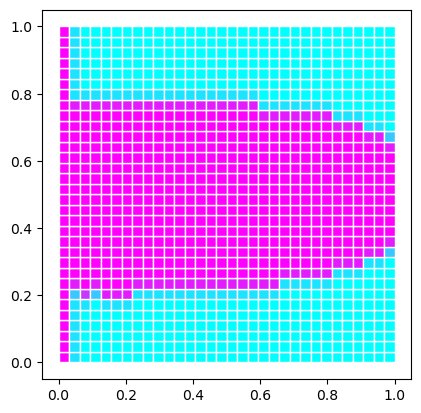

f:12.497356061255433
Volume fraction: 0.5072699652777778


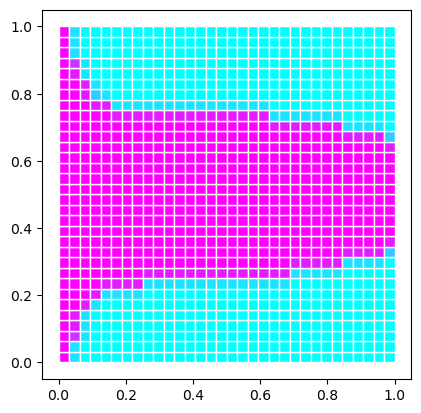

f:10.80863316162762
Volume fraction: 0.5033637152777778


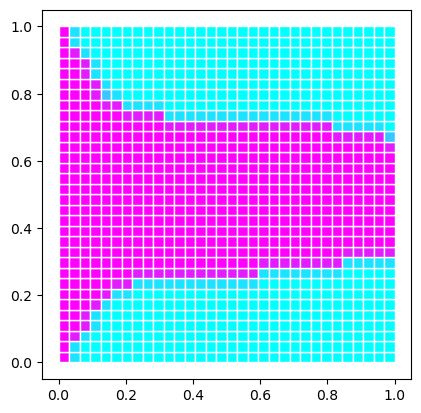

f:10.597311301275637
Volume fraction: 0.5031467013888888


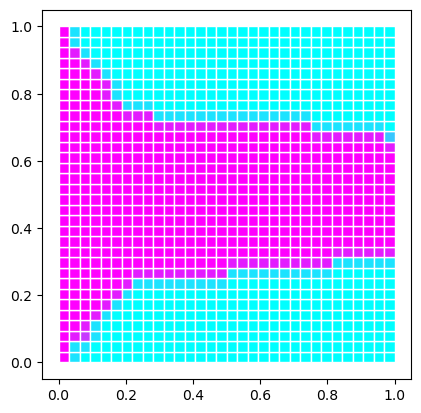

f:10.59544328154432
Volume fraction: 0.5031467013888888


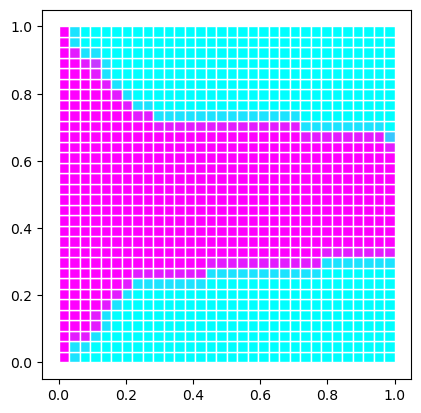

f:10.619602479171714
Volume fraction: 0.5032552083333334


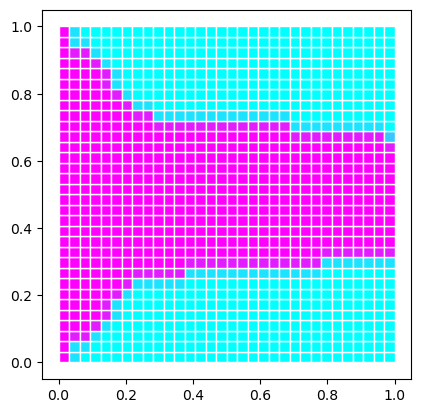

f:10.671977065504121
Volume fraction: 0.5032552083333334


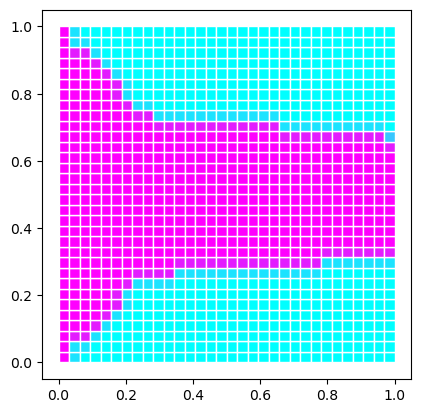

f:10.693492115296966
Volume fraction: 0.5033637152777778


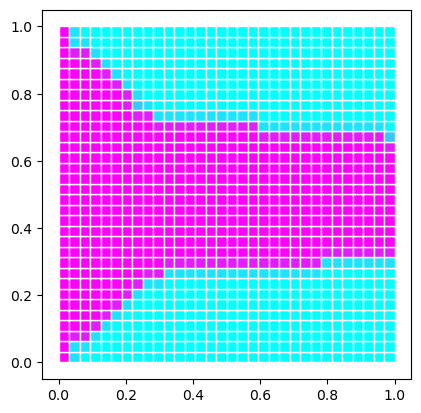

f:10.7004687511525
Volume fraction: 0.5032552083333334


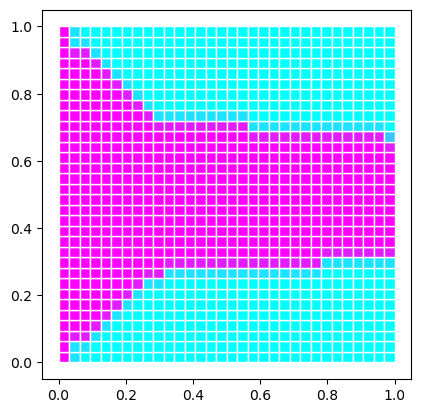

f:10.580818319512288
Volume fraction: 0.5031467013888888


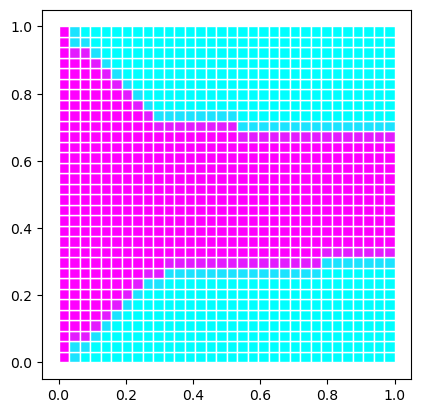

f:10.568332134960992
Volume fraction: 0.5031467013888888


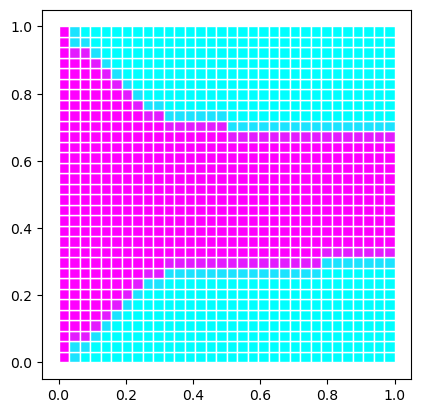

f:10.572159956482906
Volume fraction: 0.5030381944444444


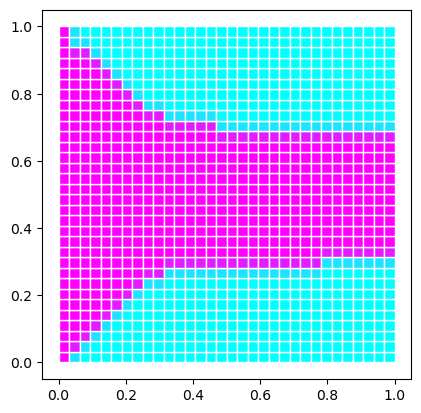

f:10.6440407143461
Volume fraction: 0.5020616319444444


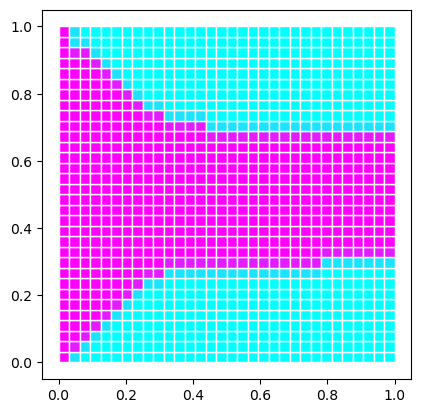

f:10.6440407143461
Volume fraction: 0.5020616319444444


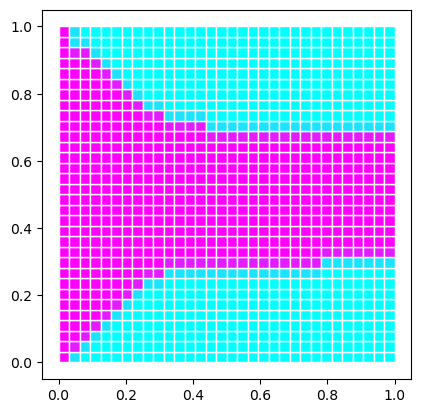

210.62588357925415


In [18]:
maxiter=15
num_bit_per = 9

start = time.time()
p,f,u,v = Q2Q1FEM.Q2Q1FEM(Node,Element,NodeBC,Node_P,Element_P,NodeBC_P,zIni)
# Q2Q1FEM.Plot_patch(nelm,Node_P,Element_P,(np.sqrt(u**2+v**2)),max(np.sqrt(u**2+v**2)),min(np.sqrt(u**2+v**2)),cmap='jet')
# print(max(np.sqrt(u**2+v**2)),min(np.sqrt(u**2+v**2)))
#p,f,u,v = PolyFEM.PolyFEM(nelm,zIni)
z_QA_new = zIni
obj = []
frac = []
for i in range(maxiter):
    #print('--- {}th iteration ---'.format(i+1))
    z_QA = z_QA_new
    # if i==0:
    #     xc = 2
    # else:
    #     xc = max(np.sqrt(u**2+v**2))
    xc=2
    solution = Construct_QUBO(fem_NElem-nelm,nelm,u,v,volfrac=0.5,num_bit_per=num_bit_per,xc=xc)
    sol = []
    # heviside=[]
    # check=[]
    for t in solution:
        pred_t_d = np.sum(t[:-1])/num_bit_per
        sol.append(pred_t_d)
        # pred_t_h = t[-1]
        # heviside.append(pred_t_h)
        # if pred_t_d >= 0.5:
        #     check.append(1)
        # else:
        #     check.append(0)
    #print('check',(np.array(check)-np.array(heviside)).sum())    
    z_QA_new = np.concatenate([np.ones(nelm),np.array(sol)])
    p,f_new,u,v = Q2Q1FEM.Q2Q1FEM(Node,Element,NodeBC,Node_P,Element_P,NodeBC_P,z_QA_new) #original
    #p,f_new,u,v = Q2Q1FEM.Q2Q1FEM(Node,Element,NodeBC,Node_P,Element_P,NodeBC_P,(0.2+(z_QA_new)*3/5)) #phi is 0.2~0.8
    #p,f_new,u,v = PolyFEM.PolyFEM(nelm,z_QA_new)
    #print(max(u**2+v**2),min(u**2+v**2),np.mean(u**2+v**2))
    #p_poly,f_new_poly,u_poly,v_poly = PolyFEM.PolyFEM(Node_P,Element_P,NodeBC_P,z_QA_new)
    print('f:{}'.format(f_new*1000))
    print('Volume fraction: {}'.format(z_QA_new.sum()/fem_NElem))
    Q2Q1FEM.Plot_patch(nelm,Node_P,Element_P,z_QA_new,1,0,cmap='cool')
    obj.append(f_new*1000)
    frac.append(z_QA_new.sum()/fem_NElem)
    #　　Q2Q1FEM.Plot_quiver(Node_P,Element_P,u,v)
    # Q2Q1FEM.Plot_patch(nelm,Node_P,Element_P,(np.sqrt(u**2+v**2)),1.2,0,cmap='jet')
    # Q2Q1FEM.Plot_patch(nelm,Node_P,Element_P,p,max(p),min(p),cmap='jet')
    # print('pressure:',max(p),min(p))
    #print(np.max(np.abs(z_QA-z_QA_new)))
    if np.max(np.abs(z_QA-z_QA_new))<0.01:
        break
end = time.time()
print(end-start)

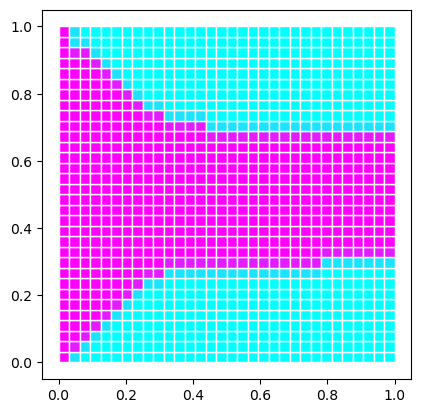

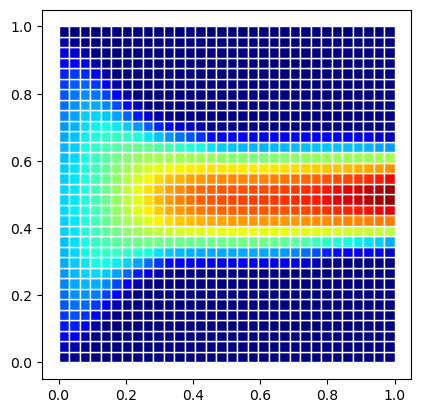

29.61200361603079
13
159.29234433174133
0.5020616319444444


In [16]:
p,f_new,u,v = Q2Q1FEM.Q2Q1FEM(Node,Element,NodeBC,Node_P,Element_P,NodeBC_P,z_QA_new) #original
#p_poly,f_new_poly,u_poly,v_poly = PolyFEM.PolyFEM(Node,Element,NodeBC,z)
p_poly,f_new_poly,u_poly,v_poly = PolyFEM.PolyFEM(Node_P,Element_P,NodeBC_P,z_QA_new)
Q2Q1FEM.Plot_patch(nelm,Node_P,Element_P,z_QA_new,1,0,cmap='cool')
Q2Q1FEM.Plot_patch(nelm,Node_P,Element_P,(np.sqrt(u**2+v**2)),3,0,cmap='jet')
print(f_new_poly)
print(i)
print(end-start)
print(z_QA_new.sum()/fem_NElem)

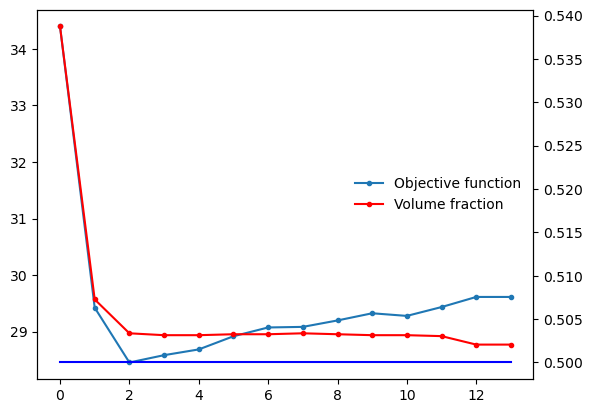

In [17]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(obj,label="Objective function",marker='.')
ax2.plot(frac,label='Volume fraction',marker='.',color='r')
ax2.plot([0,i],[0.5,0.5],color='b')
handler1, label1 = ax1.get_legend_handles_labels()
handler2, label2 = ax2.get_legend_handles_labels()
ax1.legend(handler1 + handler2, label1 + label2, loc='center right',frameon=False)

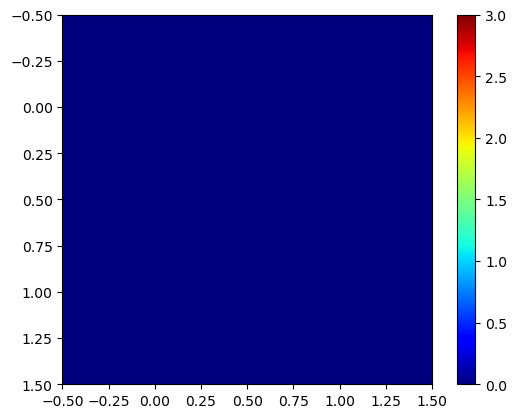

In [14]:
plt.imshow(np.zeros(4).reshape(2,2),vmin=0,vmax=3,cmap='jet')
plt.colorbar()